In [1]:
import sys 
sys.path.insert(0, '/home/yikuan/project/old/Code/')
import pandas as pd
import numpy as np
from ACM.evaluation.metrics import calibration,distributions_js, reliability_curve, expected_calibration_error, accuracy_confidence, roc_confidence
from sklearn.metrics import log_loss
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score,accuracy_score
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import math
import torch
from common.common import load_obj, H5Recorder
import pyro.distributions as distribution
import torch.nn.functional as F
from sklearn.metrics import brier_score_loss
import seaborn as sns
import torch.distributions as dist
import matplotlib

In [2]:
fileConfig = {
    'BEHRT': '/home/shared/yikuan/ACM/data/Depression/bert.h5',
    'Whitened-GP':'/home/shared/yikuan/ACM/data/Depression/bertWhitenedGP.h5',
    'KISS-GP':'/home/shared/yikuan/ACM/data/Depression/bertKISSGP.h5',
    'BE':'/home/shared/yikuan/ACM/data/Depression/bertBayesianEmbedding.h5',
    'DBGP': '/home/shared/yikuan/ACM/data/Depression/bertDBKL.h5',
    'BO': '/home/shared/yikuan/ACM/data/Depression/bertBayesianOutput.h5',
    'BE+BO': '/home/shared/yikuan/ACM/data/Depression/bertBayesianEmbeddingOutput.h5',
    'Bayesian Embedding + KISS-GP calibration': '/home/shared/yikuan/ACM/data/Depression/bertDBKLCalibration.h5'
}

color_map = {
    'BEHRT': 'b',
    'Whitened-GP':'g',
    'KISS-GP':'c',
    'BE':'orange',
    'DBGP': 'r',
    'BO': 'y',
    'BE+BO': 'pink',
    'Bayesian Embedding + KISS-GP calibration': 'grey'
}


In [3]:
# AUROC
for k,v in fileConfig.items():
    if k not in ['Bayesian Embedding + KISS-GP calibration'] :
        recorder = H5Recorder(v)
        recorder.open(read=True)
        label = recorder.read('label')
        prob = recorder.read('prob')

        if k not in ['BEHRT']:
            # AUROC of mean of predictive probabilities
            prob_mean = np.mean(prob, axis=1).reshape(-1)
            print('AUROC {}: {}'.format(k, roc_auc_score(y_true=label, y_score=prob_mean)))

            print('AUPRC {}: {}'.format(k, average_precision_score(y_true=label, y_score=prob_mean)))
    #         # mean AUROC of predictive probabilities
    #         num_sample = prob.shape[1]
    #         roc_list = []
    #         for i in range(num_sample):
    #             roc_list.append(roc_auc_score(y_true=label, y_score=prob[:,i].reshape(-1)))
    #         mean_auroc = np.mean(roc_list)
    #         std_auroc = np.std(roc_list)
    #         print('mean AUROC {}: {} and 95% CI {} | {}'.format(k, mean_auroc, mean_auroc - 1.96*std_auroc, mean_auroc + 1.96*std_auroc))
        elif k in ['BEHRT']:
            print('AUROC {}: {}'.format(k, roc_auc_score(y_true=label, y_score=prob)))
            print('AUPRC {}: {}'.format(k, average_precision_score(y_true=label, y_score=prob)))
        recorder.close()

AUROC BEHRT: 0.7865683039927411
AUPRC BEHRT: 0.4479847108982292
AUROC Whitened-GP: 0.7819443302394924
AUPRC Whitened-GP: 0.4336780848338423
AUROC KISS-GP: 0.7820491399940137
AUPRC KISS-GP: 0.43272537655489246
AUROC BE: 0.7740105917846719
AUPRC BE: 0.4098459179851822
AUROC DBGP: 0.7764756446831005
AUPRC DBGP: 0.41630928648635307
AUROC BO: 0.7717985667499313
AUPRC BO: 0.42843236438153637
AUROC BE+BO: 0.7786600059782958
AUPRC BE+BO: 0.41998919537363194


In [ ]:
# # NLL calculation
# for k,v in fileConfig.items():
#     recorder = H5Recorder(v)
#     recorder.open(read=True)
#     label = recorder.read('label')
#     prob = recorder.read('prob')
    
#     if k!='BEHRT':
#         num_sample = prob.shape[1]
#         nll_list = []
#         for i in range(num_sample):
#             nll_list.append(log_loss(y_true=label, y_pred=prob[:,i].reshape(-1)))
#         mean_nll = np.mean(nll_list)
#         print('expected log likelihood {} : {}'.format(k, mean_nll))
#     recorder.close()

In [ ]:
# # Brier score
# for k,v in fileConfig.items():
#     recorder = H5Recorder(v)
#     recorder.open(read=True)
#     label = recorder.read('label')
#     prob = recorder.read('prob')
    
#     if k!='BEHRT':
#         num_sample = prob.shape[1]
#         brier_list = []
#         for i in range(num_sample):
#             brier_list.append(brier_score_loss(y_true=label, y_prob=prob[:,i].reshape(-1)))
#         mean_brier = np.mean(brier_list)
#         print('Brier Score {} : {}'.format(k, mean_brier))
#     recorder.close()

In [3]:
font = {
    'font.size':15,
    'axes.labelsize':20,
    'xtick.labelsize':15,
    'ytick.labelsize': 15
}

matplotlib.rcParams.update(font)




Text(45.75, 0.5, 'accuracy')

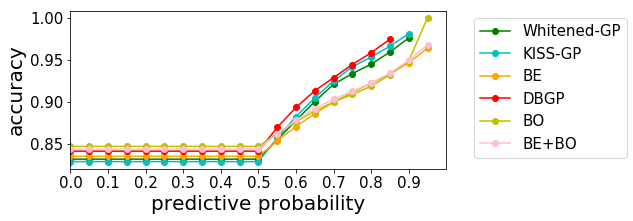

In [4]:
# Accuracy over confidence
plt.figure(figsize=(10, 3))
bins = 20

for k,v in fileConfig.items():
    if k not in ['Bayesian Embedding + KISS-GP calibration']:
        recorder = H5Recorder(v)
        recorder.open(read=True)
        label = recorder.read('label')
        prob = recorder.read('prob')

        if k not in ['BEHRT']:
            # AUROC of mean of predictive probabilities
            prob_mean = np.mean(prob, axis=1).reshape(-1)

            x, y = accuracy_confidence(prob_mean,label, bins)
            idx = ~np.isnan(y)
            x = x[idx]
            y = y[idx]

            plt.plot(x, y, c=color_map.get(k), label=k, marker='o')

        recorder.close()

plt.xticks(np.arange(0,1,step=0.1))
# plt.ylim(0.8,1)
plt.xlim(0,1)
# plt.grid()
plt.legend(bbox_to_anchor=(1.5, 1))
plt.tight_layout()
plt.xlabel('predictive probability')
plt.ylabel('accuracy')

Text(45.75, 0.5, 'auroc')

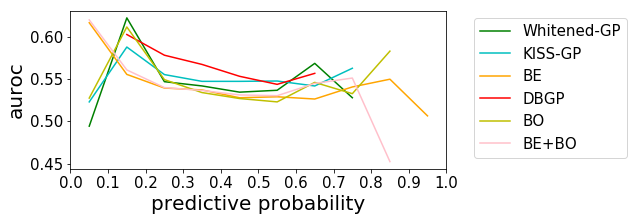

In [5]:
# ROC over confidence
plt.figure(figsize=(10, 3))
bins = 10

for k,v in fileConfig.items():
    if k not in ['Bayesian Embedding + KISS-GP calibration']:
        recorder = H5Recorder(v)
        recorder.open(read=True)
        label = recorder.read('label')
        prob = recorder.read('prob')

        if k not in ['BEHRT']:
            # AUROC of mean of predictive probabilities
            prob_mean = np.mean(prob, axis=1).reshape(-1)

            x, boundry, y = roc_confidence(prob_mean, label, bins)

            idx = ~np.isnan(y)
            x = x[idx]
            y = y[idx]
            idx = np.array(~(y==0))
            x = x[idx]
            y = y[idx]

            plt.plot(x, y, c=color_map.get(k), label=k)

        recorder.close()

plt.xticks(np.arange(0,1.1,step=0.1))
# plt.ylim(0.8,1)
plt.xlim(0,1)
# plt.grid()
plt.legend(bbox_to_anchor=(1.5, 1))
plt.tight_layout()
plt.xlabel('predictive probability')
plt.ylabel('auroc')

Text(56.925, 0.5, 'fraction of positives')

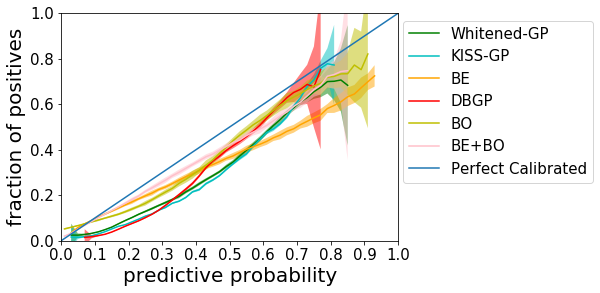

In [6]:
# calibration curve
plt.figure(figsize=(10.2, 4))
bins=50

for k,v in fileConfig.items():
    
    if k not in ['Bayesian Embedding + KISS-GP calibration']:
        recorder = H5Recorder(v)
        recorder.open(read=True)
        label = recorder.read('label')
        prob = recorder.read('prob')

        if k not in ['BEHRT']:
            num_sample = prob.shape[1]
            acc_list = []
            center_list = []
            for i in range(num_sample):
                y_score, empirical_prob, center=reliability_curve(y_true=label, y_score=prob[:,i].reshape(-1), bins=bins)
                acc_list.append(empirical_prob)
                center_list.append(center)



            acc_list = np.stack(acc_list, axis=0)
            center_list = np.stack(center_list, axis=0)

            mean_acc = np.mean(acc_list, axis=0)
            std_acc = np.std(acc_list, axis=0)
            center = np.mean(center_list, axis=0)

            idx = ~np.isnan(mean_acc)
            x = center[idx]
            y = mean_acc[idx]
            sigma = std_acc[idx]

            plt.plot(x, y, color_map.get(k), label=k)
            plt.fill(np.concatenate([x, x[::-1]]), np.concatenate([y - 1.96 * sigma,(y + 1.96 * sigma)[::-1]]),
                     alpha=.5, fc=color_map.get(k), ec='None')

        recorder.close()

plt.plot(np.linspace(0,1,bins), np.linspace(0,1, bins), label='Perfect Calibrated')
plt.xticks(np.arange(0,1.1,step=0.1))
plt.ylim(0,1)
plt.xlim(0,1)
# plt.grid()
plt.legend(bbox_to_anchor=(1.6, 1))
plt.tight_layout()
plt.xlabel('predictive probability')
plt.ylabel('fraction of positives')

In [30]:
# # calibration curve
# plt.figure()
# bins=100

# for k,v in fileConfig.items():
#     recorder = H5Recorder(v)
#     recorder.open(read=True)
#     label = recorder.read('label')
#     prob = recorder.read('prob')
    
#     if k in ['Bayesian Embedding + KISS-GP','Bayesian Embedding + KISS-GP calibration']:
#         num_sample = prob.shape[1]
#         acc_list = []
#         center_list = []
#         for i in range(num_sample):
#             y_score, empirical_prob, center=reliability_curve(y_true=label, y_score=prob[:,i].reshape(-1), bins=bins)
#             acc_list.append(empirical_prob)
#             center_list.append(center)
        
       
        
#         acc_list = np.stack(acc_list, axis=0)
#         center_list = np.stack(center_list, axis=0)

#         mean_acc = np.mean(acc_list, axis=0)
#         std_acc = np.std(acc_list, axis=0)
#         center = np.mean(center_list, axis=0)
        
#         idx = ~np.isnan(mean_acc)
#         x = center[idx]
#         y = mean_acc[idx]
#         sigma = std_acc[idx]
        
#         plt.plot(x, y, color_map.get(k), label=k)
#         plt.fill(np.concatenate([x, x[::-1]]), np.concatenate([y - 1.96 * sigma,(y + 1.96 * sigma)[::-1]]),
#                  alpha=.5, fc=color_map.get(k), ec='None')
    
#     recorder.close()

# plt.plot(np.linspace(0,1,bins), np.linspace(0,1, bins), label='Perfect Calibrated')
# plt.xticks(np.arange(0,1.1,step=0.1))
# plt.ylim(0,1)
# plt.xlim(0,1)
# plt.grid()
# plt.legend()
# plt.tight_layout()
# plt.xlabel('predictive probability')
# plt.ylabel('empirical frequency')

Text(27.125, 0.5, 'empirical frequency')

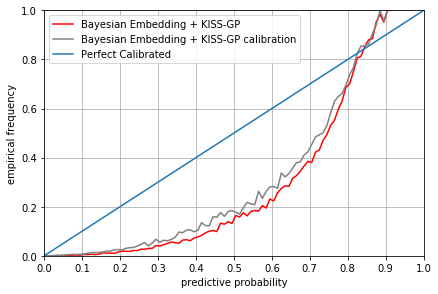

In [85]:
# # calibration curve
# plt.figure()
# bins=100

# for k,v in fileConfig.items():
#     recorder = H5Recorder(v)
#     recorder.open(read=True)
#     label = recorder.read('label')
#     prob = recorder.read('prob')
    
#     if k in ['Bayesian Embedding + KISS-GP','Bayesian Embedding + KISS-GP calibration']:
#         prob_mean = np.mean(prob, axis=1).reshape(-1)
        
# #         num_sample = prob.shape[1]
# #         acc_list = []
# #         center_list = []
# #         for i in range(num_sample):
#         y_score, empirical_prob, center=reliability_curve(y_true=label, y_score=prob_mean.reshape(-1), bins=bins)
# #             acc_list.append(empirical_prob)
# #             center_list.append(center)
        
       
        
# #         acc_list = np.stack(acc_list, axis=0)
# #         center_list = np.stack(center_list, axis=0)

# #         mean_acc = np.mean(acc_list, axis=0)
# #         std_acc = np.std(acc_list, axis=0)
# #         center = np.mean(center_list, axis=0)
        
#         idx = ~np.isnan(empirical_prob)
#         x = center[idx]
#         y = empirical_prob[idx]
# #         sigma = std_acc[idx]
        
#         plt.plot(x, y, color_map.get(k), label=k)
# #         plt.fill(np.concatenate([x, x[::-1]]), np.concatenate([y - 1.96 * sigma,(y + 1.96 * sigma)[::-1]]),
# #                  alpha=.5, fc=color_map.get(k), ec='None')
    
#     recorder.close()

# plt.plot(np.linspace(0,1,bins), np.linspace(0,1, bins), label='Perfect Calibrated')
# plt.xticks(np.arange(0,1.1,step=0.1))
# plt.ylim(0,1)
# plt.xlim(0,1)
# plt.grid()
# plt.legend()
# plt.tight_layout()
# plt.xlabel('predictive probability')
# plt.ylabel('empirical frequency')

Text(27.125, 0.5, 'auroc')

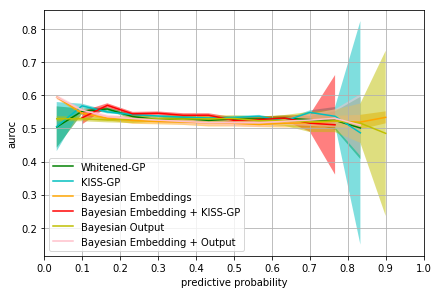

In [17]:
# AUROC with 95% ci
plt.figure()
bins=15

for k,v in fileConfig.items():
    if k not in ['Bayesian Embedding + KISS-GP calibration']:
        recorder = H5Recorder(v)
        recorder.open(read=True)
        label = recorder.read('label')
        prob = recorder.read('prob')

        if k not in ['BEHRT']:
            num_sample = prob.shape[1]
            roc_list = []
            center_list = []
            for i in range(num_sample):
                x, _, y=roc_confidence(prob[:,i].reshape(-1), label, bins)
                roc_list.append(y)
                center_list.append(x)

            roc_list = np.stack(roc_list, axis=0)
            center_list = np.stack(center_list, axis=0)

#             print(center_list)
#             print(roc_list)

            mean_roc = np.mean(roc_list, axis=0)
            std_roc = np.std(roc_list, axis=0)
            center = np.mean(center_list, axis=0)

#             print(x)
#             print(y)

            idx = ~np.isnan(mean_roc)
            x = center[idx]
            y = mean_roc[idx]
            sigma = std_roc[idx]
            
            idx = np.array(~(y==0))
            x = x[idx]
            y = y[idx]
            sigma = sigma[idx]
            
            if k in ['Bayesian Embedding + KISS-GP', 'Whitened-GP']:
                x = x[:-1]
                y = y[:-1]
                sigma = sigma[:-1]
            if k in ['Bayesian Embedding + KISS-GP']:
                x = x[1:]
                y = y[1:]
                sigma = sigma[1:]

            plt.plot(x, y, color_map.get(k), label=k)
            plt.fill(np.concatenate([x, x[::-1]]), np.concatenate([y - 1.96 * sigma,(y + 1.96 * sigma)[::-1]]),
                     alpha=.5, fc=color_map.get(k), ec='None')

        recorder.close()

# plt.plot(np.linspace(0,1,bins), np.linspace(0,1, bins), label='Perfect Calibrated')
plt.xticks(np.arange(0,1.1,step=0.1))
# plt.ylim(0,1)
plt.xlim(0,1)
plt.grid()
plt.legend()
plt.tight_layout()
plt.xlabel('predictive probability')
plt.ylabel('auroc')

Text(27.125, 0.5, 'count')

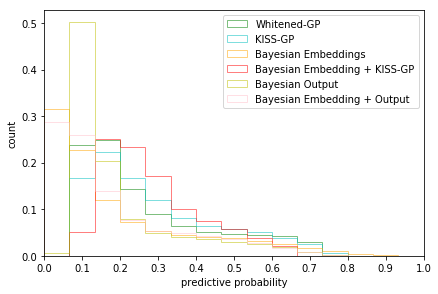

In [12]:
# Uncertainty difference for samples with probability fall into specific group
n_bins=15
plt.figure()
# for patient ever with sample probability higher than 0.9
for k,v in fileConfig.items():
    if k not in['Bayesian Embedding + KISS-GP calibration']:
        recorder = H5Recorder(v)
        recorder.open(read=True)
        label = recorder.read('label')
        prob = recorder.read('prob')

        label = np.array(label)
        prob = np.array(prob)

        if k not in ['BEHRT']:
            # consider patients whoes 95% CI fall into 0.9 contribute to the uncertain
            mean_prob = np.mean(prob, axis=1).reshape(-1)
            std_prob = np.std(prob, axis=1).reshape(-1)
    #         high_bound = mean_prob + 1.96*std_prob
    #         idx = np.where(high_bound>0.9)[0]
    #         idx, cnt = np.unique(np.where(prob>0.9)[0],return_counts=True)

    #         idx = idx[cnt>1]

    #         # select those patient
    #         patient_prob = mean_prob[idx]
    #         patient_std = std_prob[idx]
    #         patient_label = label[idx]
    #         plt.hist(mean_prob, np.linspace(0,1,n_bins+1), histtype='step', color=color_map.get(k), label=k, alpha=0.5)
            plt.hist(mean_prob, np.linspace(0,1,n_bins+1),alpha=0.5, histtype='step', color=color_map.get(k), label=k,  weights=np.ones(len(mean_prob)) / len(mean_prob))
        recorder.close()

plt.xticks(np.linspace(0,1,11))
plt.xlim(0,1)
plt.legend(loc=0)
plt.tight_layout()
plt.xlabel('predictive probability')
plt.ylabel('count')

kl divergence Whitened-GP:0.0826481282711029
kl divergence KISS-GP:0.12676945328712463
kl divergence BE:0.008538286201655865
kl divergence DBGP:0.008670954965054989
kl divergence BO:0.044708847999572754
kl divergence BE+BO:0.009107884019613266


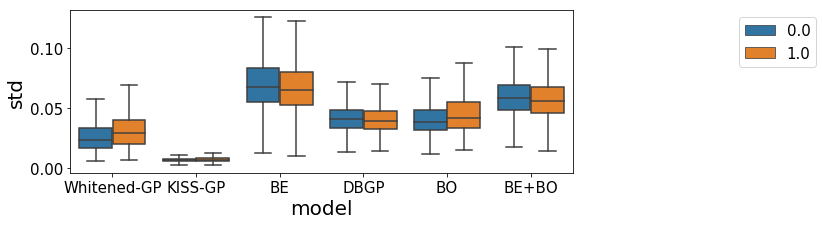

In [8]:
# Uncertainty difference for samples with probability fall into specific group
n_bins=15

df_list = []

plt.figure(figsize=(9,3))
# for patient ever with sample probability higher than 0.9
for k,v in fileConfig.items():
    if k not in ['Bayesian Embedding + KISS-GP calibration']:
        recorder = H5Recorder(v)
        recorder.open(read=True)
        label = recorder.read('label')
        prob = recorder.read('prob')

        label = np.array(label)
        prob = np.array(prob)

        if k not in ['BEHRT']:
    #     if k in ['Bayesian Embedding + KISS-GP']:
            # consider patients whoes 95% CI fall into 0.9 contribute to the uncertain
            mean_prob = np.mean(prob, axis=1).reshape(-1)
            std_prob = np.std(prob, axis=1).reshape(-1)

    #         high_bound = mean_prob + 1.96*std_prob
    #         idx = np.where(high_bound>0.9)[0]


    #         idx, cnt = np.unique(np.where(prob>0.9)[0],return_counts=True)

    #         idx = idx[cnt>1]

    #         # select those patient
    #         patient_prob = mean_prob[idx]
    #         patient_std = std_prob[idx]
    #         patient_label = label[idx]

            # select patient with mean prob > 0.8
            idx = (mean_prob>0.5)&(mean_prob<1)

            patient_prob = mean_prob[idx]
            patient_std = std_prob[idx]
            patient_label = label[idx]
            
            patient_pos = patient_std[patient_label==1]
            patient_neg = patient_std[patient_label==0]

            pos_dist = torch.distributions.Normal(loc=torch.tensor(np.mean(patient_pos)), scale=torch.tensor(np.std(patient_pos)))
            neg_dist = torch.distributions.Normal(loc=torch.tensor(np.mean(patient_neg)), scale=torch.tensor(np.std(patient_neg)))
            kl = dist.kl_divergence(neg_dist, pos_dist)
            print('kl divergence {}:{}'.format(k, kl))


            temp_df = pd.DataFrame({'model': k, 'label': patient_label, 'std': patient_std})
            df_list.append(temp_df)


    #         plt.hist(patient_prob, np.linspace(0,1,n_bins+1), histtype='step', color=color_map.get(k), label=k)
    #         plt.hist(patient_prob, np.linspace(0,1,n_bins+1), histtype='step', color=color_map.get(k), label=k,  weights=np.ones(len(patient_prob)) / len(patient_prob))
        recorder.close()
    
df = pd.concat(df_list)

sns.boxplot(x="model", y='std', hue="label",data=df, showfliers=False)
plt.legend(bbox_to_anchor=(1.5, 1))
# plt.xticks(np.linspace(0,1,11))
# plt.xlim(0,1)
# plt.legend(loc=2)
# plt.tight_layout()
# plt.xlabel('predictive probability')
# plt.ylabel('count')

In [ ]:
# # Expected calibration error
# n_bins= 10
# for k,v in fileConfig.items():
#     recorder = H5Recorder(v)
#     recorder.open(read=True)
#     label = recorder.read('label')
#     prob = recorder.read('prob')
    
#     if k not in ['BEHRT']:
#         # ECE of mean of predictive probabilities
#         prob_mean = np.mean(prob, axis=1).reshape(-1)
#         print('ECE {}: {}'.format(k, expected_calibration_error(y_true=label, y_score=prob_mean, bins=n_bins)))

#         # mean ECE of predictive probabilities
#         num_sample = prob.shape[1]
#         ece_list = []
#         for i in range(num_sample):
#             ece_list.append(expected_calibration_error(y_true=label, y_score=prob[:,i].reshape(-1), bins=n_bins))
# #         print(len(ece_list))
#         mean_ece = np.mean(ece_list)
#         std_ece = np.std(ece_list)
#         print('mean ECE {}: {} and 95% CI {} | {}'.format(k, mean_ece, mean_ece - 1.96*std_ece, mean_ece + 1.96*std_ece))
#     recorder.close()

In [22]:
# Embedding Analysis
weights = torch.load('/home/shared/yikuan/ACM/model/Depression/behrtDBKLEmbeddingsPretrain_best.bin')
word_dict = load_obj('/home/shared/yikuan/HF/Data/PureICD/Full_vocab')['token2idx']
word_emb_loc = weights['bert.embeddings.word_embeddings.weight_posterior.loc'].cpu()
word_emb_scale = weights['bert.embeddings.word_embeddings.weight_posterior.scale'].cpu()
sigma = F.softplus(word_emb_scale)
dist = distribution.Normal(loc=word_emb_loc, scale=sigma)
entropy = dist.entropy().sum(dim=1)
entropy_df = pd.DataFrame({'code': list(word_dict.keys()), 'entropy':entropy.numpy()})

# word_cnt = pd.read_parquet('/home/yikuan/project/project/Script/BertDeepKernelGP/vocab_count.parquet')

In [23]:
entropy_df.sort_values(by='entropy', ascending=True)[0:15]

,code,entropy
1891,0403,-229.685974
2,SEP,-227.912872
1506,F419,-221.345932
1478,J111,-220.693512
1862,0402,-219.647430
3,CLS,-219.600601
1892,0407,-219.578674
1871,0401,-219.360992
1881,0106,-219.242065
1528,M545,-219.148804


In [24]:
entropy_df.sort_values(by='entropy', ascending=False)[0:15]

,code,entropy
59,M678,-210.284348
1659,0304/0309,-210.794418
337,B079,-210.806168
491,B088,-210.839218
981,B372,-210.949585
1640,6104,-210.994995
570,C250,-211.138321
30,B269,-211.159210
1310,F341,-211.244705
77,D62,-211.251862
